In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, chirp
import tensorflow as tf
from tensorflow.keras import backend as K
import pandas as pd
from tensorflow.keras.layers import Input, GRU, Dense, Masking, Reshape, BatchNormalization, Flatten, Conv1DTranspose, RepeatVector, TimeDistributed, Bidirectional, Activation, GaussianNoise, Lambda, LayerNormalization, Conv1D, MaxPool1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import Model
import tensorflow_probability as tfp

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Data

In [2]:
DATA = np.load('./Data/AsanTRSet.npy')

#### Env setting

In [3]:
save_path = './Results/'
if not os.path.exists(save_path):
    os.mkdir(save_path)
    
### Model checkpoint
ModelSaveSameName = save_path+'FeatExtM_ver2.1.hdf5'
ModelSave = ModelCheckpoint(filepath=ModelSaveSameName, monitor='val_mse', verbose=1, save_best_only=True )

### Model Early stop
EarlyStop = EarlyStopping(monitor='val_loss', patience=500)

LatDim = 2
SigDim = DATA.shape[1]
MaskingRate = 0.05
NoiseStd = 0.002
MaskStd = 0.1
ReparaStd = 0.1

In [4]:
def MaskingGen ( InpRegul, MaskingRate = 0.025, MaskStd = 0.1):
    ## Masking vector generation 1 vs 0
    NBatch = tf.shape(InpRegul)[0]
    
    MaskIDX = tf.random.shuffle(tf.range(NBatch * InpRegul.shape[1] ))
    CutIDX = tf.cast(  tf.cast(tf.shape(MaskIDX)[0], dtype=tf.float32) * (1-MaskingRate), dtype=tf.int32 )
    MaskIDX = tf.cast(MaskIDX < CutIDX, dtype=tf.float32)
    MaskVec = tf.reshape(MaskIDX, (NBatch, -1))[:,:,None]
    
    ## Noise vector generation 1 vs 0; Enocder 에서는 masking {0 vs 1}을 통해 BP가 되지 않도록 제어; Filtering (feature extracting) part에서는 encoder에서 masking 된 부분에 noise를 추가해줌
    RevMaskIDX = MaskIDX == 0
    RevMaskIDX = tf.cast(RevMaskIDX, dtype=tf.float32)
    NoisVec = RevMaskIDX * tf.random.normal(tf.shape(RevMaskIDX), stddev=MaskStd)
    NoisVec = tf.reshape(NoisVec, (NBatch, -1))[:,:,None]
    return MaskVec, NoisVec

def GenLowFilter (LF, N = 401):
    nVec = np.arange(N)
    Window = tf.signal.hamming_window(N)

    # A low-pass filter
    X = 2 * LF * (nVec - (N - 1) / 2)
    X = tf.maximum(X , 1e-7)
    LPF = tf.sin(np.pi*X)/(np.pi*X)
    LPF *= Window
    LPF /= tf.reduce_sum(LPF, axis=-1, keepdims=True)
    
    return LPF[:,None] 


def GenHighFilter (HF, N = 401):
    nVec = np.arange(N)
    Window = tf.signal.hamming_window(N)

    # A high-pass filter
    Y = 2 * HF * (nVec - (N - 1) / 2)
    Y = tf.maximum(Y , 1e-7)
    HPF = tf.sin(np.pi*Y)/(np.pi*Y)
    HPF *= Window
    HPF /= tf.reduce_sum(HPF, axis=-1, keepdims=True)
    HPF = -HPF

    ## HPF[(N - 1) // 2] += 1
    Mask = np.zeros(HPF.shape[1])
    Mask[(N - 1) // 2] += 1
    Mask = tf.constant(Mask, dtype=tf.float32)
    HPF = HPF + Mask
    
    return HPF[:,None] 


def ParaFilters (layer):
    
    layer = Dense(2, activation='linear')(layer)
    
    return Activation('sigmoid')(layer[:, 0:1])


def ReName (layer, name):
    return Lambda(lambda x: x, name=name)(layer)

### Encoder

In [5]:
def EncoderModel (SigDim, LatDim= 2, Type = '', MaskingRate = 0.025, NoiseStd = 0.002, MaskStd = 0.1, ReparaStd = 0.1 ,training = False):
    InpL = Input(shape=(SigDim,))
    InpFrame = tf.signal.frame(InpL, 100, 100)

    if training:
        InpRegul = GaussianNoise(stddev=NoiseStd)(InpFrame, training=training)
        MaskVec, NoisVec = MaskingGen(InpRegul, MaskingRate, MaskStd)
        EncInp = Masking(mask_value=0.)(InpRegul * MaskVec )
        EncOut = InpRegul + NoisVec
    else:
        EncInp, EncOut = InpFrame, InpFrame

    Encoder = Dense(40, activation='softplus')(InpFrame)
    Encoder = Bidirectional(GRU(30, return_sequences=True))(Encoder)
    Encoder = Bidirectional(GRU(20, return_sequences=False))(Encoder)
    Encoder = Dense(50, activation='softplus')(Encoder)
    Encoder = Dense(30, activation='softplus')(Encoder)
    Encoder = Dense(15, activation='softplus')(Encoder)

    Z_Mean_ft = Dense(LatDim, activation='linear')(Encoder)
    Z_Log_Sigma_ft = Dense(LatDim, activation='softplus')(Encoder)
    Z_Log_Sigma_ft = ReName(Z_Log_Sigma_ft,'Z_Log_Sigma_'+Type)

    # Reparameterization Trick for sampling 
    Epsilon = tf.random.normal(shape=(tf.shape(Z_Mean_ft)[0], Z_Mean_ft.shape[1]), mean=0., stddev=ReparaStd)

    if training==False:
        Epsilon = Epsilon * 0

    Z_Mean_ft = Z_Mean_ft + tf.exp(0.5 * Z_Log_Sigma_ft) * Epsilon
    Z_Mean_ft = ReName(Z_Mean_ft,'Z_Mean_'+Type)

    #EncModel = Model(InpL, [Flatten()(EncOut), Z_Mean_ft, Z_Log_Sigma_ft], name='EncoderModel')
    
    return [InpL], [Flatten()(EncOut), Z_Mean_ft, Z_Log_Sigma_ft]

### FeatExtract

In [6]:
def FeatExtractModel(Inps, LatDim= 2, FiltLenList = [301, 301, 301, 301, 301, 301] ):
    
    EncReInp, InpZ = Inps
    
    H_F = ParaFilters(Dense(2, activation= 'softplus')(InpZ))
    L_F = ParaFilters(Dense(2, activation= 'softplus')(InpZ))
    HH_F = ParaFilters(Dense(2, activation= 'softplus')(InpZ))
    HL_F = ParaFilters(Dense(2, activation= 'softplus')(InpZ))
    LH_F = ParaFilters(Dense(2, activation= 'softplus')(InpZ))
    LL_F = ParaFilters(Dense(2, activation= 'softplus')(InpZ))


    ### Filtering level 1 -------------------------------------------------------------------
    ## Filter generation
    To_H = GenHighFilter(H_F,  N=FiltLenList[0])
    To_L = GenLowFilter(L_F, N=FiltLenList[1])

    ## Perform signal filtering level 1
    InpFrame =  tf.signal.frame(EncReInp, To_H.shape[-1], 1)
    Sig_H = tf.reduce_sum(InpFrame*To_H[:,:,::-1], axis=-1, keepdims=True)
    Sig_H = ReName(Sig_H, 'Sig_H')

    InpFrame =  tf.signal.frame(EncReInp, To_L.shape[-1], 1)
    Sig_L = tf.reduce_sum(InpFrame*To_L[:,:,::-1], axis=-1, keepdims=True)
    Sig_L = ReName(Sig_L, 'Sig_L')



    ### Filtering level HH and HL (from Sig_H) -------------------------------------------------------------------
    ## Filter generation
    To_HH = GenHighFilter(HH_F, N=FiltLenList[2])
    To_HL = GenLowFilter(HL_F, N=FiltLenList[3])

    ## Perform signal filtering level 2
    Frame_H =  tf.signal.frame(Sig_H[:,:,0], To_HH.shape[-1], 1)
    Sig_HH = tf.reduce_sum(Frame_H*To_HH[:,:,::-1], axis=-1, keepdims=True)
    Sig_HH = ReName(Sig_HH, 'Sig_HH')

    Frame_H =  tf.signal.frame(Sig_H[:,:,0], To_HL.shape[-1], 1)
    Sig_HL = tf.reduce_sum(Frame_H*To_HL[:,:,::-1], axis=-1, keepdims=True)
    Sig_HL = ReName(Sig_HL, 'Sig_HL')


    ### Filtering level LH and LL (from Sig_L) -------------------------------------------------------------------
    ## Filter generation
    To_LH = GenHighFilter(LH_F,  N=FiltLenList[4])
    To_LL = GenLowFilter(LL_F,  N=FiltLenList[5])

    ## Perform signal filtering level 2
    Frame_L =  tf.signal.frame(Sig_L[:,:,0], To_LH.shape[-1], 1)
    Sig_LH = tf.reduce_sum(Frame_L*To_LH[:,:,::-1], axis=-1, keepdims=True)
    Sig_LH = ReName(Sig_LH, 'Sig_LH')

    Frame_L =  tf.signal.frame(Sig_L[:,:,0], To_LL.shape[-1], 1)
    Sig_LL = tf.reduce_sum(Frame_L*To_LL[:,:,::-1], axis=-1, keepdims=True)
    Sig_LL = ReName(Sig_LL, 'Sig_LL')

    #FeatExM = Model([EncReInp, InpZ], [Flatten()(Sig_HH), Flatten()(Sig_HL), Flatten()(Sig_LH), Flatten()(Sig_LL)], name='FeatExtractModel')
    
    return [Flatten()(Sig_HH), Flatten()(Sig_HL), Flatten()(Sig_LH), Flatten()(Sig_LL)]

### Decoder

In [7]:
def DecoderModel(Inps ):
    
    Sig_HH, Sig_HL, Sig_LH, Sig_LL = Inps 

    ## GRU NET -------------------------------------------------------------------
    Dec_Sig_HH = Reshape((-1, 100))(Sig_HH)
    Dec_Sig_HL = Reshape((-1, 100))(Sig_HL)
    Dec_Sig_LH = Reshape((-1, 100))(Sig_LH)
    Dec_Sig_LL = Reshape((-1, 100))(Sig_LL)

    Dec_Sig_HH = Bidirectional(GRU(5), name='Dec_Sig_HH')(Dec_Sig_HH)
    Dec_Sig_HL = Bidirectional(GRU(5), name='Dec_Sig_HL')(Dec_Sig_HL)
    Dec_Sig_LH = Bidirectional(GRU(5), name='Dec_Sig_LH')(Dec_Sig_LH)
    Dec_Sig_LL = Bidirectional(GRU(5), name='Dec_Sig_LL')(Dec_Sig_LL)

    Decoder = tf.concat([ Dec_Sig_HH, Dec_Sig_HL, Dec_Sig_LH, Dec_Sig_LL], axis=1)
    Decoder = RepeatVector((SigDim//100) )(Decoder)
    Decoder = Bidirectional(GRU(50, return_sequences=True))(Decoder)
    Decoder = Dense(100, activation='softplus')(Decoder)
    #Decoder = Bidirectional(GRU(50, return_sequences=True))(Decoder)
    DecOut = Dense(100, activation='sigmoid')(Decoder)
    DecOut = Reshape((SigDim,),name='Out')(DecOut)
    #DecModel = Model([Sig_HH, Sig_HL, Sig_LH, Sig_LL], DecOut, name='DecoderModel')
    
    return DecOut

### Vae Loss; RecMSE and KL Divergence¶

In [8]:
# Model definition
EncInp, EncOut = EncoderModel(SigDim=SigDim, Type = 'FX', MaskingRate = MaskingRate, NoiseStd = NoiseStd, MaskStd = MaskStd, ReparaStd = ReparaStd, training=True) 
FeatExtOut = FeatExtractModel(EncOut[:2])
DecOut =DecoderModel(FeatExtOut)
FXModel = Model(EncInp[0], DecOut)
FXModel.compile(optimizer='adam', loss=tf.losses.mean_squared_error, metrics={"Out":'mse'})

# Apply beta and capacity
Capacity = 0.0# 0.1 0.05
Beta = 1.0 # 0.01

# Vae Loss; KL Divergence
Z_Sampled, Z_Log_Sigma = FXModel.get_layer('Z_Mean_FX').output,FXModel.get_layer('Z_Log_Sigma_FX').output
kl_Loss = 0.5 * tf.reduce_sum( Z_Sampled**2  +  tf.exp(Z_Log_Sigma)- Z_Log_Sigma-1, axis=1)    
kl_Loss = tf.reduce_mean(kl_Loss )
kl_Loss = Beta * tf.abs(kl_Loss - Capacity)


FXModel.add_loss(kl_Loss )
FXModel.add_metric(kl_Loss, 'KL_D')

FXModel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
tf.signal.frame (TFOpLambda)    (None, 10, 100)      0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10, 40)       4040        tf.signal.frame[0][0]            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 10, 60)       12960       dense[0][0]                      
______________________________________________________________________________________________

In [10]:
FXModel.load_weights(ModelSaveSameName)
ModelSave = ModelCheckpoint(filepath=ModelSaveSameName, monitor='val_mse', verbose=1, save_best_only=True )

FXModel.fit(DATA[:], DATA[:], batch_size=3000, epochs=200, shuffle=True, validation_split=0.2, callbacks=[ModelSave, EarlyStop])

Epoch 1/200
107/107 [==============================] - 53s 433ms/step - loss: 0.0108 - mse: 7.7179e-04 - KL_D: 0.0100 - val_loss: 0.0109 - val_mse: 7.7559e-04 - val_KL_D: 0.0101

Epoch 00001: val_mse improved from inf to 0.00078, saving model to ./Results\FeatExtM_ver2.1.hdf5
Epoch 2/200
107/107 [==============================] - 40s 376ms/step - loss: 0.0108 - mse: 7.7046e-04 - KL_D: 0.0100 - val_loss: 0.0108 - val_mse: 7.7604e-04 - val_KL_D: 0.0100

Epoch 00002: val_mse did not improve from 0.00078
Epoch 3/200
107/107 [==============================] - 40s 373ms/step - loss: 0.0108 - mse: 7.7048e-04 - KL_D: 0.0100 - val_loss: 0.0109 - val_mse: 7.7382e-04 - val_KL_D: 0.0101

Epoch 00003: val_mse improved from 0.00078 to 0.00077, saving model to ./Results\FeatExtM_ver2.1.hdf5
Epoch 4/200
107/107 [==============================] - 41s 381ms/step - loss: 0.0108 - mse: 7.7196e-04 - KL_D: 0.0100 - val_loss: 0.0108 - val_mse: 7.7924e-04 - val_KL_D: 0.0100

Epoch 00004: val_mse did not impro

KeyboardInterrupt: 

### Post analysis

In [ ]:
EncInp, EncOut = EncoderModel(SigDim=SigDim,  Type = 'FX', training=False)
FeatExtOut = FeatExtractModel(EncOut[:2])
DecOut =DecoderModel(FeatExtOut)
PostFXModel = Model(EncInp[0], DecOut)
PostFXModel.compile(optimizer='adam', loss=tf.losses.mean_squared_error, metrics={"Out":'mse'})
PostFXModel.load_weights(ModelSaveSameName)


#### Rec pred with given zMean

In [ ]:
PostFXModel.load_weights(ModelSaveSameName)
PostFXModel.compile(optimizer='adam', loss=tf.losses.mean_squared_error, metrics={"Out":'mse'})

Pred =PostFXModel.predict(DATA[:], batch_size=2000, verbose=1)
#PostFXModel.evaluate(DATA[:20], DATA[:20], batch_size=2000, verbose=1)


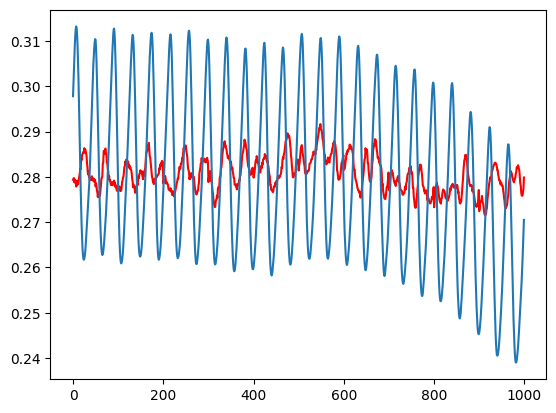

In [18]:
idx= 2
plt.plot(Pred[idx], c='red')
plt.plot(DATA[idx])


<KerasTensor: shape=(None, 12) dtype=float32 (created by layer 'Z_Mean_ft_FX')>

### Model reconstruction

In [95]:
### Define total model again
EncInp, EncOut = EncoderModel(SigDim=SigDim,  Type = 'FX', training=False)
FeatExtOut = FeatExtractModel(EncOut[:2])
DecOut =DecoderModel(FeatExtOut)
PostFXModel = Model(EncInp[0], DecOut)
PostFXModel.compile(optimizer='adam', loss=tf.losses.mean_squared_error, metrics={"Out":'mse'})
PostFXModel.load_weights(ModelSaveSameName)


### Weight extract
FeatExtractStartIDX = len(Model(EncInp, EncOut).layers) - 1
FeatExtractEndIDX = len(Model(EncInp, FeatExtractModel(EncOut[:2])).layers)
FeatExtractLayers = PostFXModel.layers[FeatExtractStartIDX:FeatExtractEndIDX]

FeatExtractLayersWeights = []
for i in FeatExtractLayers:
    FeatExtractLayersWeights.extend(i.get_weights())

    
### Define a sub-model
Post_EncReInp = Input((SigDim,))
Post_InpZ = Input((LatDim,))
Post_FeatExtOut = FeatExtractModel([Post_EncReInp , Post_InpZ])
Post_FeatExtModel = Model([Post_EncReInp, Post_InpZ], Post_FeatExtOut)
Post_FeatExtModel.set_weights(FeatExtractLayersWeights)


### Components pred

In [107]:
Sig_HH = Post_FeatExtModel.get_layer('Sig_HH').output
Sig_HL = Post_FeatExtModel.get_layer('Sig_HL').output
Sig_LH = Post_FeatExtModel.get_layer('Sig_LH').output
Sig_LL = Post_FeatExtModel.get_layer('Sig_LL').output
LatModel = Model(Post_FeatExtModel.input, [Sig_HH, Sig_HL, Sig_LH, Sig_LL])

Pred_ZMean = Model(EncInp, EncOut[1]).predict(DATA[:], verbose=1, batch_size=3000)
PredLat = LatModel.predict([DATA[:],Pred_ZMean], verbose=1, batch_size=3000 )


134/134 [==============================] - 25s 189ms/step


#### Variational pred

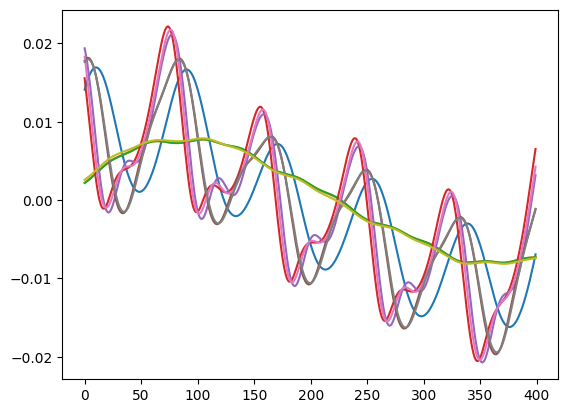

In [130]:
def RandZ (n=10):
    return np.concatenate([np.random.normal(0, 5, 2)[None] for i in range(n)])

SampleID = 1

Pred_ZSampled = RandZ(10)
DataSample = np.tile(DATA[SampleID:SampleID+1].T, 10).T
PredLat = LatModel.predict([DataSample,Pred_ZSampled] )

idx = 2
#plt.plot(DATA[idx])
for i in range(9):
    plt.plot(PredLat[idx][i, :1000, 0])
    #print(PredLat[i].shape)

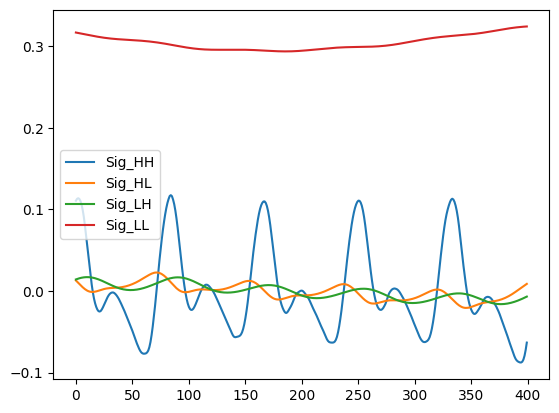

In [133]:
plt.plot(PredLat[0][idx, :, 0], label='Sig_HH')
plt.plot(PredLat[1][idx, :, 0], label='Sig_HL')
plt.plot(PredLat[2][idx, :, 0], label='Sig_LH')
plt.plot(PredLat[3][idx, :, 0], label='Sig_LL')
plt.legend()